## IMPORTING NECESSARY LIBRARIES

In [84]:
import numpy as np
import pandas as  pd
from sklearn.model_selection import train_test_split
from dateutil.relativedelta import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import pickle
import os


## LOADING DATASET

In [85]:
data = pd.read_csv('raw_data.csv')

## DATA OVERVIEW

In [86]:
data.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3,7.0,6.9,0.52


In [87]:
data.tail()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
22745,fffe31003500370039003100,2008-12-30,Female,Service,No,1,3.0,NaN,0.41
22746,fffe33003000350031003800,2008-01-19,Female,Product,Yes,3,6.0,6.7,0.59
22747,fffe390032003000,2008-11-05,Male,Service,Yes,3,7.0,NaN,0.72
22748,fffe33003300320036003900,2008-01-10,Female,Service,No,2,5.0,5.9,0.52
22749,fffe3400350031003800,2008-01-06,Male,Product,No,3,6.0,7.8,0.61


In [88]:
data.describe()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
count,22750.000000,21369.000000,20633.000000,21626.000000
mean,2.178725,4.481398,5.728188,0.452005
std,1.135145,2.047211,1.920839,0.198226
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,3.000000,4.600000,0.310000
50%,2.000000,4.000000,5.900000,0.450000
75%,3.000000,6.000000,7.100000,0.590000
max,5.000000,10.000000,10.000000,1.000000


In [89]:
data.shape

(22750, 9)

In [90]:
data.size

204750

In [91]:
data.columns.tolist()

['Employee ID',
 'Date of Joining',
 'Gender',
 'Company Type',
 'WFH Setup Available',
 'Designation',
 'Resource Allocation',
 'Mental Fatigue Score',
 'Burn Rate']

In [92]:
data.nunique()

Employee ID             22750
Date of Joining           366
Gender                      2
Company Type                2
WFH Setup Available         2
Designation                 6
Resource Allocation        10
Mental Fatigue Score      101
Burn Rate                 101
dtype: int64

In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           22750 non-null  object 
 1   Date of Joining       22750 non-null  object 
 2   Gender                22750 non-null  object 
 3   Company Type          22750 non-null  object 
 4   WFH Setup Available   22750 non-null  object 
 5   Designation           22750 non-null  int64  
 6   Resource Allocation   21369 non-null  float64
 7   Mental Fatigue Score  20633 non-null  float64
 8   Burn Rate             21626 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 1.6+ MB


In [94]:
data.isnull().sum()

Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
dtype: int64

In [95]:
data.isnull().sum().values.sum()

4622

## Exploratory Data Analysis

There are NaN values on our target ("Burn Rate") and also in Resource Allocation and Mental Fatigue Score columns. As we are going to perform supervised linear regression, our target variable is needed to do so. Therefore, this 1124 rows with NaN values must be dropped off of our dataframe.


In [96]:
data.corr(numeric_only=True)['Burn Rate'][:-1]


Designation             0.737556
Resource Allocation     0.856278
Mental Fatigue Score    0.944546
Name: Burn Rate, dtype: float64

These two variables are strongly correlated with target variable, therefore , important to estimate it.

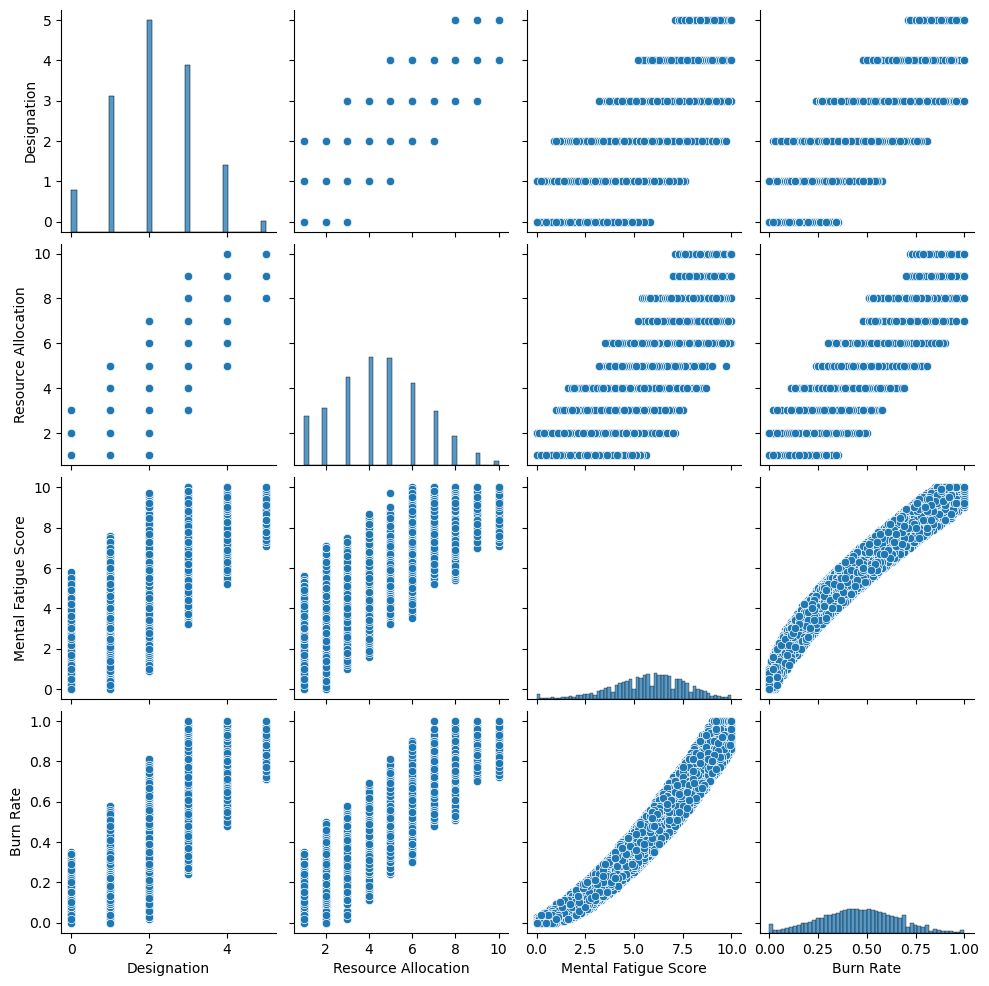

In [97]:
sns.pairplot(data)
plt.show()

Drop off all observations with NaN values of our dataframe.

In [98]:
data = data.dropna()


In [99]:
data.shape

(18590, 9)

Analyzing what type of data is each variable.

In [100]:
data.dtypes

Employee ID              object
Date of Joining          object
Gender                   object
Company Type             object
WFH Setup Available      object
Designation               int64
Resource Allocation     float64
Mental Fatigue Score    float64
Burn Rate               float64
dtype: object

 The values that each variable contains.

In [101]:
data_obj = data.select_dtypes(object)
# prints a dictionary of max 10 unique values for each non-numeric column
pprint({ c : data_obj[c].unique()[:10] for c in data_obj.columns})


{'Company Type': array(['Service', 'Product'], dtype=object),
 'Date of Joining': array(['2008-09-30', '2008-11-30', '2008-11-03', '2008-07-24',
       '2008-11-26', '2008-01-02', '2008-10-31', '2008-03-16',
       '2008-05-12', '2008-05-14'], dtype=object),
 'Employee ID': array(['fffe32003000360033003200', 'fffe3700360033003500',
       'fffe32003400380032003900', 'fffe31003900340031003600',
       'fffe3300350037003500', 'fffe33003300340039003100',
       'fffe32003600320037003400', 'fffe33003100330032003700',
       'fffe3400310035003800', 'fffe33003100330036003300'], dtype=object),
 'Gender': array(['Female', 'Male'], dtype=object),
 'WFH Setup Available': array(['No', 'Yes'], dtype=object)}


 The employees ID doesn't provide any useful information and, therefore, they must be dropped.

In [102]:
data = data.drop('Employee ID', axis = 1)


Checking the correlation of Date of Joining with Target variable

Min date 2008-01-01
Max date 2008-12-31


<Axes: xlabel='Month', ylabel='Hired employees'>

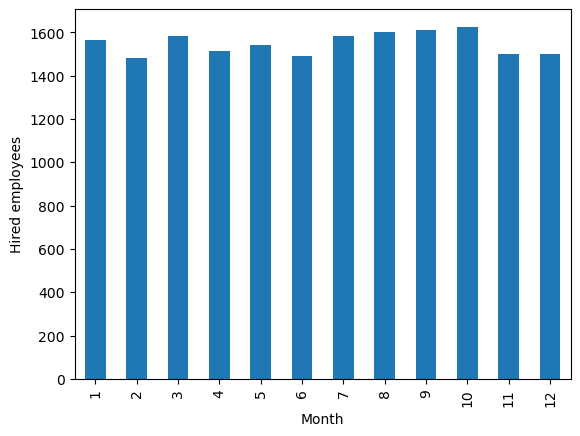

In [103]:
print(f"Min date {data['Date of Joining'].min()}")
print(f"Max date {data['Date of Joining'].max()}")
data_month = data.copy()

data_month["Date of Joining"] = data_month['Date of Joining'].astype("datetime64")
data_month["Date of Joining"].groupby(
    data_month['Date of Joining'].dt.month
).count().plot(kind="bar", xlabel='Month', ylabel="Hired employees")


 The date of joining is uniform distributed with values between 2008-01-01 and 2008-12-31. So in order to create a new feature which represents the labor seniority, we could create a variable with de days worked

In [104]:
data_2008 = pd.to_datetime(["2008-01-01"]*len(data))
data["Days"] = data['Date of Joining'].astype("datetime64").sub(data_2008).dt.days
data.Days

0        273
1        334
3        307
4        205
5        330
        ... 
22743    349
22744    147
22746     18
22748      9
22749      5
Name: Days, Length: 18590, dtype: int64

In [105]:
data.corr()['Burn Rate']


C:\Users\CSE\AppData\Local\Temp\ipykernel_11896\1249983522.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()['Burn Rate']


Designation             0.736412
Resource Allocation     0.855005
Mental Fatigue Score    0.944389
Burn Rate               1.000000
Days                    0.000309
Name: Burn Rate, dtype: float64

In [106]:
data.corr(numeric_only=True)['Burn Rate'][:]

Designation             0.736412
Resource Allocation     0.855005
Mental Fatigue Score    0.944389
Burn Rate               1.000000
Days                    0.000309
Name: Burn Rate, dtype: float64

We observed that there is no strong correlation between Date of Joining and Burn Rate.So, we are dropping the column Date of Joining.

In [107]:
data = data.drop(['Date of Joining','Days'], axis = 1)

In [108]:
data.head()

,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,Female,Service,No,2,3.0,3.8,0.16
1,Male,Service,Yes,1,2.0,5.0,0.36
3,Male,Service,Yes,1,1.0,2.6,0.20
4,Female,Service,No,3,7.0,6.9,0.52
5,Male,Product,Yes,2,4.0,3.6,0.29


Now  analysing the categorical variables

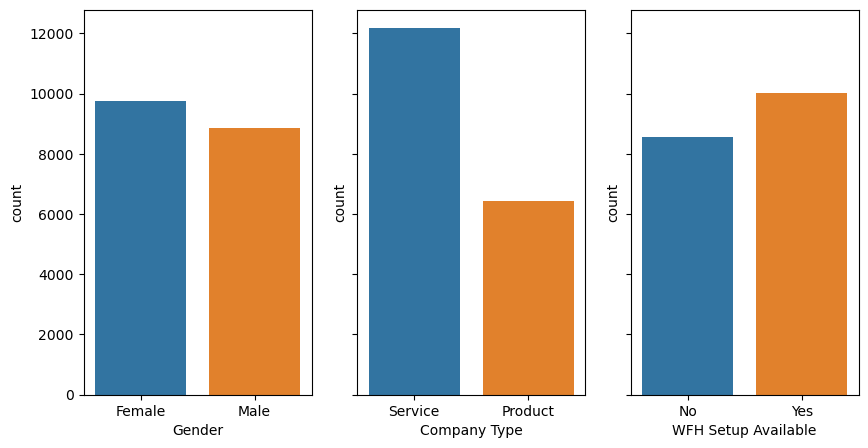

In [109]:
cat_columns = data.select_dtypes(object).columns
fig, ax = plt.subplots(nrows=1, ncols=len(cat_columns), sharey=True, figsize=(10, 5))
for i, c in enumerate(cat_columns):
    sns.countplot(x=c, data=data, ax=ax[i])
plt.show()


The number of observations of each category on each variable is equally distributed, except to the Company_Type where the number of service jobs its almost twice that of product ones.


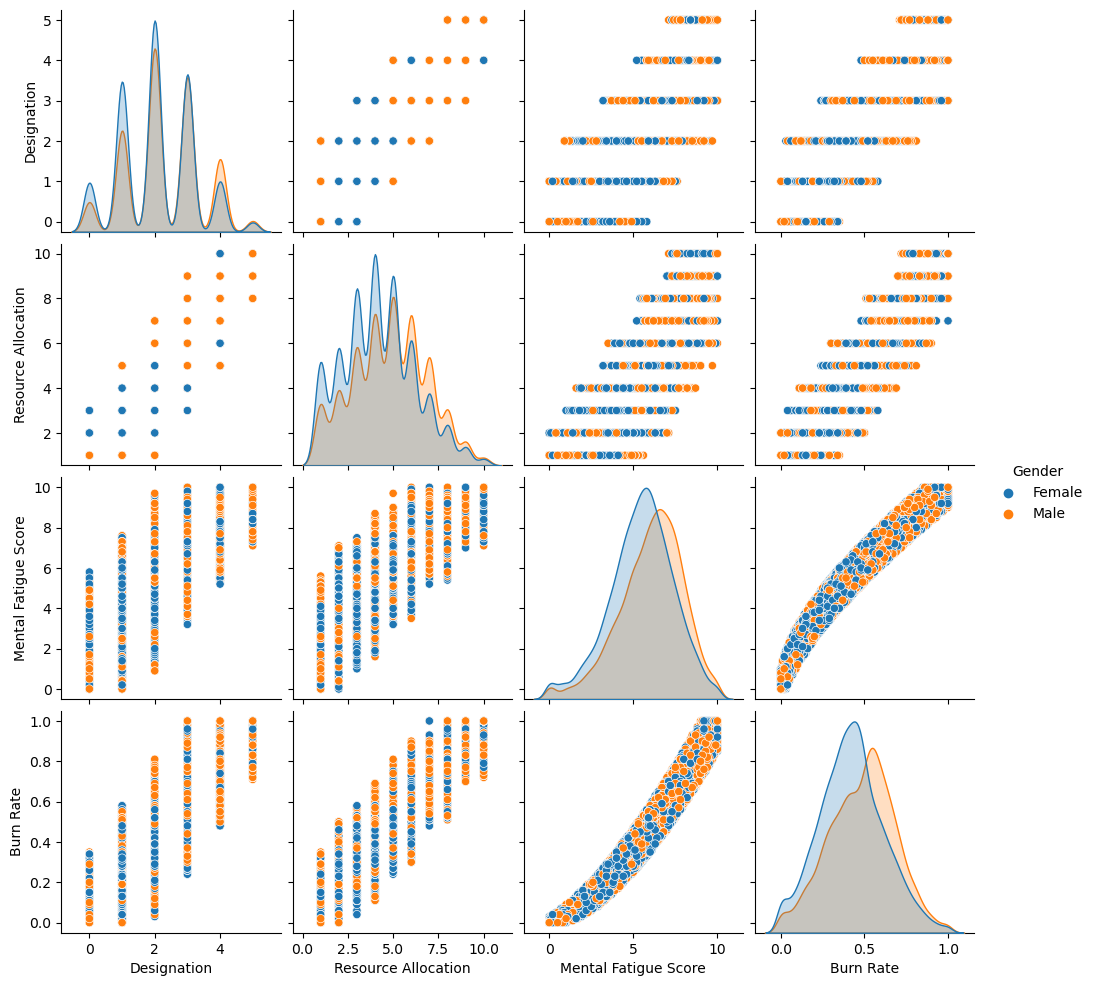

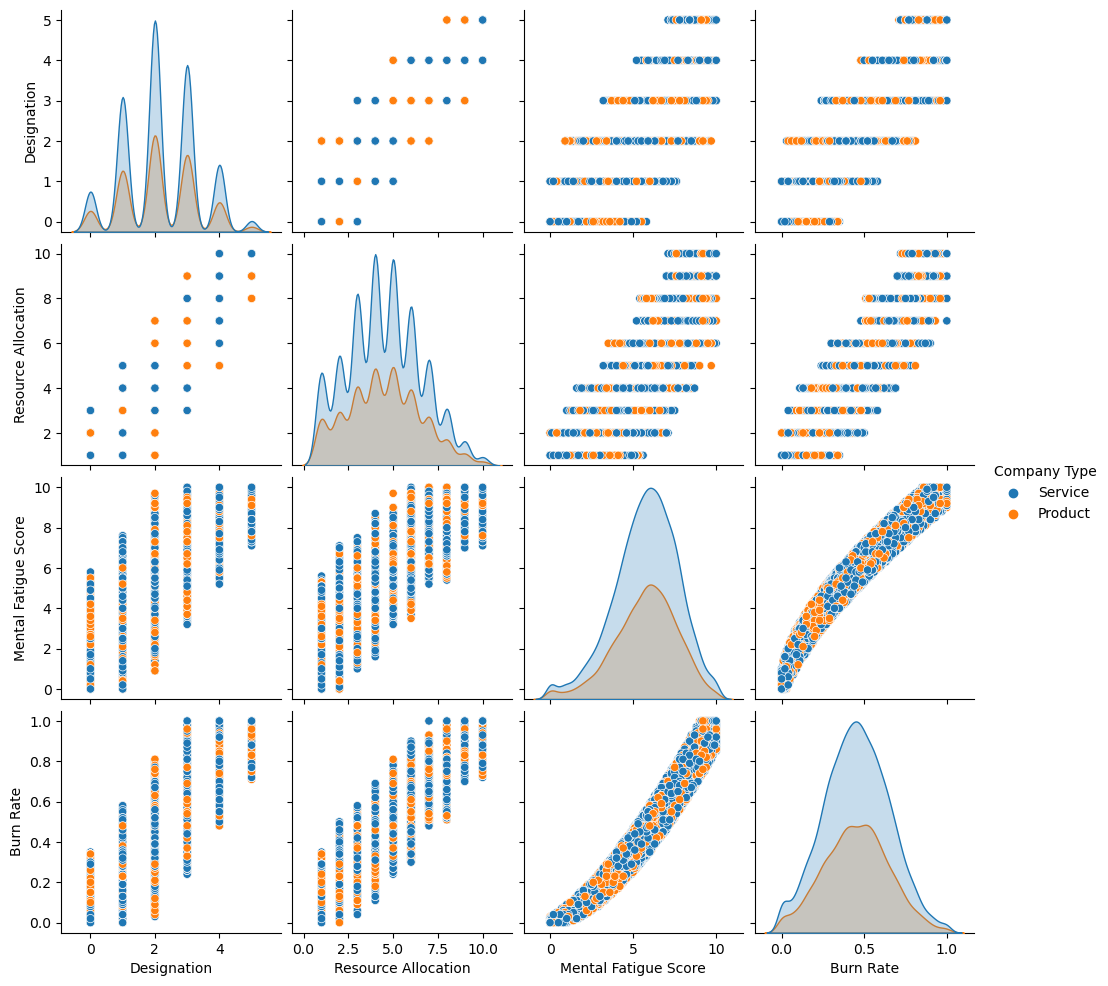

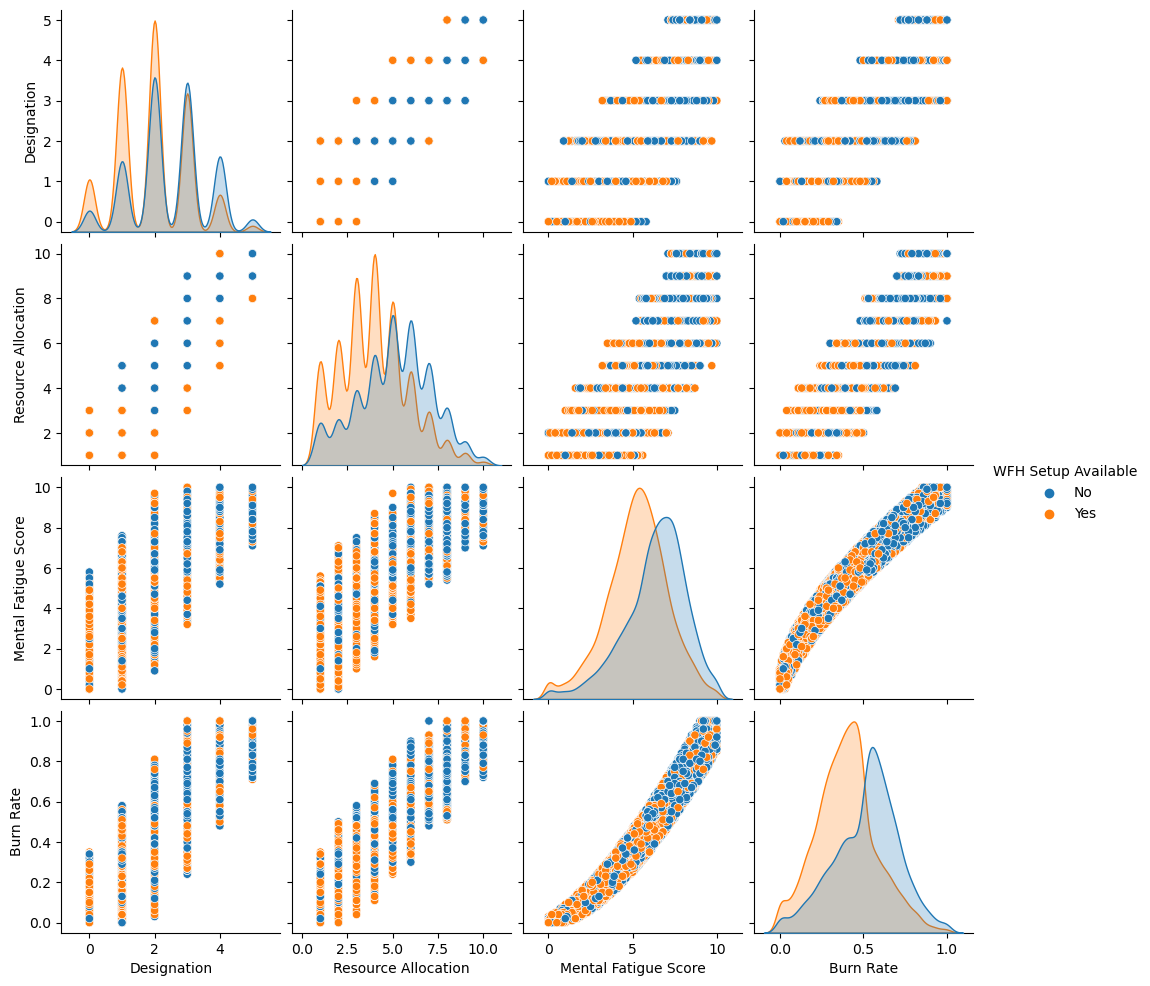

In [110]:
for c in data.select_dtypes(object).columns:
    sns.pairplot(data, hue=c)
plt.show()

In [111]:
data.columns

Index(['Gender', 'Company Type', 'WFH Setup Available', 'Designation',
       'Resource Allocation', 'Mental Fatigue Score', 'Burn Rate'],
      dtype='object')

#### One-Hot Encoding for categorical features

In [112]:
data = pd.get_dummies(data, columns=['Company Type', 'WFH Setup Available',
       'Gender'], drop_first=True)
data.head()
encoded_columns = data.columns



# Preprocessing

In [77]:
# Split df into X and y
y = data['Burn Rate']
X = data.drop('Burn Rate', axis=1)


In [78]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
# Scale X
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns )

In [79]:
X_train

,Designation,Resource Allocation,Mental Fatigue Score,Company Type_Service,WFH Setup Available_Yes,Gender_Male
8977,0.723327,0.250185,-0.061773,0.724706,-1.082297,1.051505
14115,-0.159330,0.250185,-0.941481,0.724706,-1.082297,-0.951018
8797,0.723327,0.250185,0.973179,0.724706,-1.082297,-0.951018
1173,-1.041987,-1.214568,-0.579248,-1.379869,-1.082297,-0.951018
1941,-0.159330,0.738436,1.180169,-1.379869,0.923961,1.051505
...,...,...,...,...,...,...
13453,0.723327,1.226687,1.645897,-1.379869,0.923961,-0.951018
21179,0.723327,0.250185,-1.044976,0.724706,0.923961,1.051505
6327,0.723327,0.250185,0.093470,0.724706,-1.082297,1.051505
14933,-0.159330,0.250185,0.714441,0.724706,-1.082297,1.051505


In [34]:
y_train

8977     0.41
14115    0.34
8797     0.61
1173     0.35
1941     0.61
         ... 
13453    0.78
21179    0.30
6327     0.42
14933    0.54
288      0.57
Name: Burn Rate, Length: 13013, dtype: float64

## Model Building

## Linear Regression

In [36]:
#from sklearn.linear_model import LinearRegression

# Create an instance of the LinearRegression class
linear_regression_model = LinearRegression()

# Train the model
linear_regression_model.fit(X_train, y_train)


LinearRegression()

In [37]:
#Linear Regressing Model Performance Metrics

print("Linear Regression Model Performance Metrics:\n")
# Make predictions on the test set
y_pred = linear_regression_model.predict(X_test)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate root mean squared error
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

# Calculate mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)
print("R-squared Score:", r2)

Linear Regression Model Performance Metrics:

Mean Squared Error: 0.0031569779113610717
Root Mean Squared Error: 0.0561869905882231
Mean Absolute Error: 0.04595032032644773
R-squared Score: 0.918822674247248


In [38]:
feature_names = X.columns.tolist()
feature_names

['Designation',
 'Resource Allocation',
 'Mental Fatigue Score',
 'Company Type_Service',
 'WFH Setup Available_Yes',
 'Gender_Male']

# Support Vector Machine(Linear Kernel)

In [42]:
# Create an instance of LinearSVR and explicitly set 'dual' to 'auto' to avoid the FutureWarning
SVMLinear = LinearSVR(max_iter=10000)  # You can adjust 'max_iter' as needed

# Fit the model
SVMLinear.fit(X_train, y_train)


LinearSVR(max_iter=10000)

In [43]:
#Support Vector Machine (Linear Kernel) Performance Metrics
print("Support Vector Machine (Linear Kernel) Performance Metrics\n")
# Make predictions on the test set
y_pred = SVMLinear.predict(X_test)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate root mean squared error
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

# Calculate mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)
print("R-squared Score:", r2)


Support Vector Machine (Linear Kernel) Performance Metrics

Mean Squared Error: 0.0031953727090297908
Root Mean Squared Error: 0.056527627838339284
Mean Absolute Error: 0.04590523779455061
R-squared Score: 0.9178354050660642


### By seeing the above  models, we can clearly say that Linear Regression model gives the highest accuarcy when compared to Linear SVM model.